In [87]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
from tcn import TCN
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Concatenate, Attention, Dropout
from tensorflow.keras.callbacks import EarlyStopping            
from tensorflow.keras.optimizers import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from memory_profiler import memory_usage

import warnings
warnings.filterwarnings('ignore')


In [88]:
file_path = "/home/yizhen/honours-programme-project/job_datasets/job_data.parquet"
df = pd.read_parquet(file_path)


In [89]:
selected_features = ['node_memory_Percpu_bytes', 
                     'node_context_switches_total', 
                     'surfsara_power_usage', 
                     'node_netstat_Tcp_InSegs', 
                     'node_netstat_Tcp_OutSegs', 
                     'node_network_transmit_packets_total-sum', 
                     'node_filesystem_size_bytes-sum', 
                     'node_filesystem_files-sum', 
                     'node_memory_MemFree_bytes', 
                     'node_netstat_Tcp_InErrs']

In [90]:
# Define time intervals
time_intervals = {'minute': '1T', 'hour': '1H', 'day': '1D'}

# Set sequence length
sequence_length = 30

# Number of time steps to predict into the future
prediction_steps = 7

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [91]:
# Function to prepare data
def prepare_data(data, time_interval):
    data.set_index('timestamp', inplace=True)
    data_resampled = data.resample(time_interval).sum()
    
    target_min = data_resampled['target'].min()
    target_max = data_resampled['target'].max()
    data_resampled['target'] = (data_resampled['target'] - target_min) / (target_max - target_min)
    
    return data_resampled

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]['target']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [92]:
# Function to create a hybrid model with attention mechanism
def create_attention_hybrid_model(lstm_model, tcn_model):
    lstm_input = lstm_model.input
    tcn_input = tcn_model.input

    # Get the output layers of both models
    lstm_output = lstm_model.layers[-1].output
    tcn_output = tcn_model.layers[-1].output

    # Use Attention mechanism to combine outputs
    attention = Attention()([lstm_output, tcn_output])
    merged = Concatenate()([lstm_output, tcn_output, attention])

    # Add a dense layer for the final prediction
    merged = Dense(1, activation='sigmoid')(merged)

    # Create the ensemble model
    ensemble_model = Model(inputs=[lstm_input, tcn_input], outputs=merged)

    # Compile the model
    ensemble_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

    return ensemble_model


In [93]:
# Function to make predictions on new data for the hybrid model
def predict_future_failures_hybrid(model, input_data_lstm, input_data_tcn, sequence_length, prediction_steps):
    predictions = []

    for _ in range(prediction_steps):
        # Make predictions for the next time step using both LSTM and TCN models
        prediction = model.predict([input_data_lstm.reshape(1, sequence_length, input_data_lstm.shape[1]),
                                    input_data_tcn.reshape(1, sequence_length, input_data_tcn.shape[1])])
        predictions.append(prediction[0, 0])

        # Shift the input data by one time step and append the new prediction
        input_data_lstm = np.roll(input_data_lstm, shift=-1, axis=0)
        input_data_lstm[-1, -1] = prediction[0, 0]

        input_data_tcn = np.roll(input_data_tcn, shift=-1, axis=0)
        input_data_tcn[-1, -1] = prediction[0, 0]

    return predictions


# 30 days -> 7 days

In [94]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [95]:
# Prepare data with daily intervals
data_day = prepare_data(df_selected, time_intervals['day'])

# Create sequences and targets
sequences_day, targets_day = create_sequences(data_day, sequence_length)

# Define the index to split the data
split_index_day = int(len(sequences_day) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_day, X_test_day = sequences_day[:split_index_day], sequences_day[split_index_day:]
y_train_day, y_test_day = targets_day[:split_index_day], targets_day[split_index_day:]

# Build the LSTM model
lstm_model_day = Sequential()
lstm_model_day.add(LSTM(10, input_shape=(X_train_day.shape[1], X_train_day.shape[2])))
lstm_model_day.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0005)
lstm_model_day.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

# Train the model
lstm_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.1)

# Build the TCN model
tcn_model_day = Sequential([
    TCN(input_shape=(sequence_length, X_train_day.shape[2])),
    Dense(1, activation='sigmoid')
])
tcn_model_day.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
tcn_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.15)

# Create the hybrid model
hybrid_model_attention_day = create_attention_hybrid_model(lstm_model_day, tcn_model_day)

# Train the hybrid model with both LSTM and TCN data
history_day = hybrid_model_attention_day.fit([X_train_day, X_train_day], y_train_day, epochs=20, batch_size=32, validation_split=0.15)


Epoch 1/20
2/2 [==============================] - 2s 475ms/step - loss: 0.1947 - mean_squared_error: 0.1947 - val_loss: 0.2577 - val_mean_squared_error: 0.2577
Epoch 2/20
2/2 [==============================] - 0s 65ms/step - loss: 0.1919 - mean_squared_error: 0.1919 - val_loss: 0.2570 - val_mean_squared_error: 0.2570
Epoch 3/20
2/2 [==============================] - 0s 67ms/step - loss: 0.1894 - mean_squared_error: 0.1894 - val_loss: 0.2563 - val_mean_squared_error: 0.2563
Epoch 4/20
2/2 [==============================] - 0s 63ms/step - loss: 0.1832 - mean_squared_error: 0.1832 - val_loss: 0.2554 - val_mean_squared_error: 0.2554
Epoch 5/20
2/2 [==============================] - 0s 62ms/step - loss: 0.1724 - mean_squared_error: 0.1724 - val_loss: 0.2548 - val_mean_squared_error: 0.2548
Epoch 6/20
2/2 [==============================] - 0s 59ms/step - loss: 0.1693 - mean_squared_error: 0.1693 - val_loss: 0.2541 - val_mean_squared_error: 0.2541
Epoch 7/20
2/2 [=============================

## Performance_Day

In [96]:
# Evaluate the model using Mean Squared Error
mse_day = hybrid_model_attention_day.evaluate([X_test_day, X_test_day], y_test_day, verbose=0)[1]
print(f'Mean Squared Error: {mse_day:.4f}\n')


Mean Squared Error: 0.1890



In [97]:
# Evaluate model on test data
y_pred_day = hybrid_model_attention_day.predict([X_test_day, X_test_day])

# Calculate Root Mean Squared Error
rmse_day = mean_squared_error(y_test_day, y_pred_day, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_day:.4f}\n')

# Calculate Mean Absolute Error
mae_day = mean_absolute_error(y_test_day, y_pred_day)
print(f'Mean Abosolute Error: {mae_day:.4f}\n')

# Calculate R-squared
r2_day = r2_score(y_test_day, y_pred_day)
print(f'R-squared (R2): {r2_day:.4f}\n')


1/1 [==============================] - 1s 697ms/step
Root Mean Squared Error (RMSE): 0.4347

Mean Abosolute Error: 0.3923

R-squared (R2): -2.3484



### Training and Validation Loss Plot

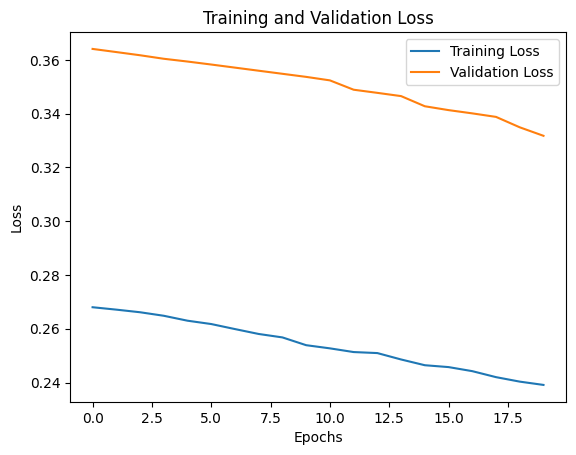

In [98]:
# Plot training and validation loss
plt.plot(history_day.history['loss'], label='Training Loss')
plt.plot(history_day.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 23ms/step
Predicted failures for the next 7 days:
[0.566104, 0.566104, 0.58574414, 0.6087889, 0.6087889, 0.6087889, 0.6087889]

Mean Squared Error for Predictions: 0.2493

Mean Absolute Error for Predictions: 0.4705


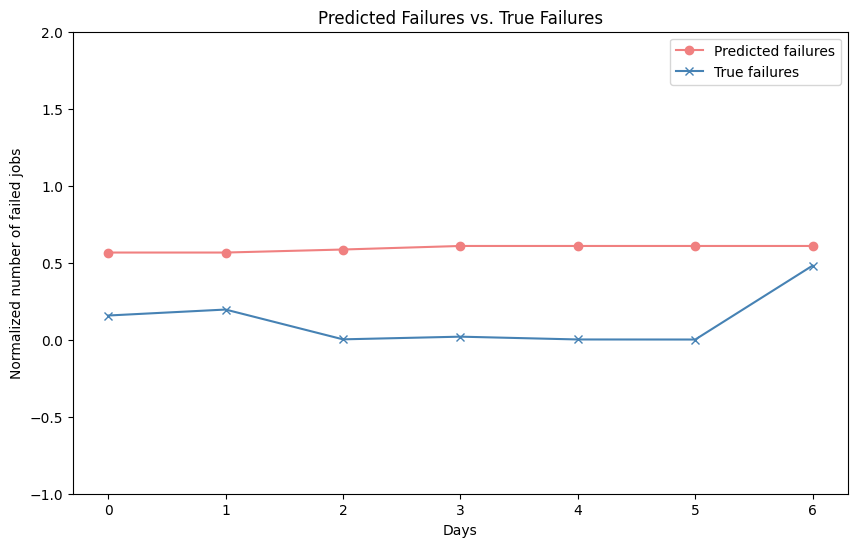

In [182]:
index_day = 2  # Can be any valid starting point

input_data_day = X_test_day[index_day]

# Make predictions
predicted_failures_day = predict_future_failures_hybrid(hybrid_model_attention_day, input_data_day, input_data_day, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_day = np.array(predicted_failures_day) * (target_max_day - target_min_day) + target_min_day

# Get the true failures for the specified number of days
true_failures_day = y_test_day[index_day:index_day + prediction_steps]

# Print the predicted failures
print("Predicted failures for the next 7 days:")
print(predicted_failures_day)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_day - true_failures_day)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_day - true_failures_day))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_day, label='Predicted failures', color='lightcoral', marker='o')
plt.plot(true_failures_day, label='True failures', color='steelblue', marker='x')
plt.xlabel('Days')
plt.ylabel('Normalized number of failed jobs')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.ylim(-1, 2)
plt.grid(False)
plt.show()


# 30 hours -> 7 hours

In [100]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [101]:
# Prepare data with hourly intervals
data_hour = prepare_data(df_selected, time_intervals['hour'])

# Create sequences and targets
sequences_hour, targets_hour = create_sequences(data_hour, sequence_length)

# Define the index to split the data
split_index_hour = int(len(sequences_hour) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_hour, X_test_hour = sequences_hour[:split_index_hour], sequences_hour[split_index_hour:]
y_train_hour, y_test_hour = targets_hour[:split_index_hour], targets_hour[split_index_hour:]

# Build the LSTM model
lstm_model_hour = Sequential()
lstm_model_hour.add(LSTM(20, input_shape=(X_train_hour.shape[1], X_train_hour.shape[2])))
lstm_model_hour.add(Dense(1, activation='sigmoid'))
lstm_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
lstm_model_hour.fit(X_train_hour, y_train_hour, epochs=10, batch_size=16, validation_split=0.15)

# Build the TCN model
tcn_model_hour = Sequential([
    TCN(input_shape=(sequence_length, X_train_hour.shape[2])),
    Dense(1, activation='sigmoid')
])
tcn_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
tcn_model_hour.fit(X_train_hour, y_train_hour, epochs=20, batch_size=32, validation_split=0.1)

# Create the hybrid model
hybrid_model_attention_hour = create_attention_hybrid_model(lstm_model_hour, tcn_model_hour)

# Train the hybrid model with both LSTM and TCN data
history_hour = hybrid_model_attention_hour.fit([X_train_hour, X_train_hour], y_train_hour, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/10
102/102 [==============================] - 4s 24ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2/10
102/102 [==============================] - 2s 20ms/step - loss: 7.1804e-04 - mean_squared_error: 7.1804e-04 - val_loss: 7.1958e-04 - val_mean_squared_error: 7.1958e-04
Epoch 3/10
102/102 [==============================] - 2s 20ms/step - loss: 3.9438e-04 - mean_squared_error: 3.9438e-04 - val_loss: 6.3148e-04 - val_mean_squared_error: 6.3148e-04
Epoch 4/10
102/102 [==============================] - 2s 20ms/step - loss: 3.6661e-04 - mean_squared_error: 3.6661e-04 - val_loss: 4.9585e-04 - val_mean_squared_error: 4.9585e-04
Epoch 5/10
102/102 [==============================] - 2s 20ms/step - loss: 3.5926e-04 - mean_squared_error: 3.5926e-04 - val_loss: 6.1361e-04 - val_mean_squared_error: 6.1361e-04
Epoch 6/10
102/102 [==============================] - 2s 19ms/step - loss: 3.5053e-04 - mean_squared_error: 3.5053e-04 - 

## Performance_Hour

In [102]:
# Evaluate the model using Mean Squared Error
mse_hour = hybrid_model_attention_hour.evaluate([X_test_hour, X_test_hour], y_test_hour, verbose=0)[1]
print(f'Mean Squared Error: {mse_hour:.4f}\n')


Mean Squared Error: 0.0129



In [103]:
# Evaluate model on test data
y_pred_hour = hybrid_model_attention_hour.predict([X_test_hour, X_test_hour])

# Calculate Root Mean Squared Error
rmse_hour = mean_squared_error(y_test_hour, y_pred_hour, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_hour:.4f}\n')

# Calculate Mean Absolute Error
mae_hour = mean_absolute_error(y_test_hour, y_pred_hour)
print(f'Mean Abosolute Error: {mae_hour:.4f}\n')

# Calculate R-squared
r2_hour = r2_score(y_test_hour, y_pred_hour)
print(f'R-squared (R2): {r2_hour:.4f}\n')


26/26 [==============================] - 1s 17ms/step
Root Mean Squared Error (RMSE): 0.1136

Mean Abosolute Error: 0.1001

R-squared (R2): -1.4508



### Training and Validation Loss Plot

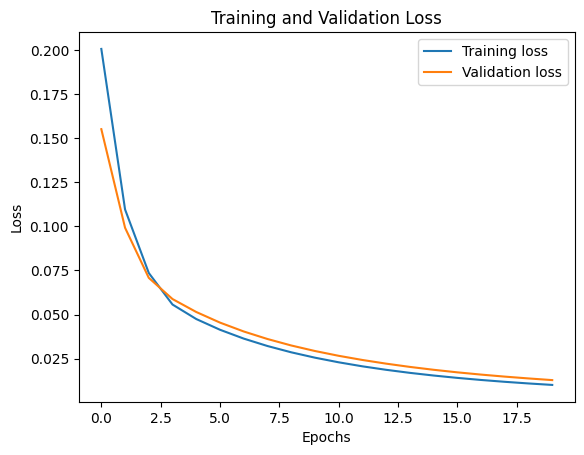

In [104]:
# Plot training and validation loss
plt.plot(history_hour.history['loss'], label='Training loss')
plt.plot(history_hour.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Predicted failures for the next 7 hours:
[0.58921, 0.5954767, 0.59888655, 0.5694386, 0.5661, 0.5661316, 0.59588087]

Mean Squared Error for Predictions: 0.1887

Mean Absolute Error for Predictions: 0.3943


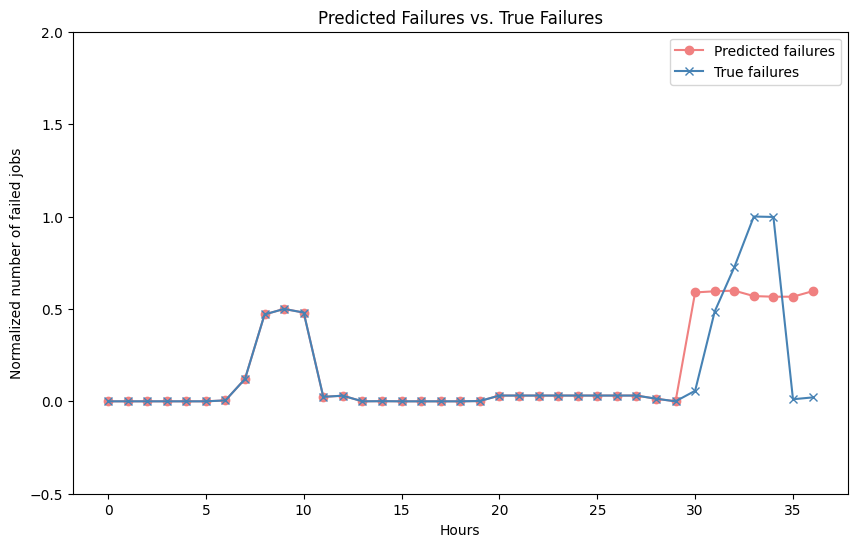

In [180]:
index_hour = 403 # Can be any valid starting point

input_data_hour = X_test_hour[index_hour]
previous_true_failures_hour = y_test_hour[index_hour:index_hour + sequence_length]

# Make predictions
predicted_failures_hour = predict_future_failures_hybrid(hybrid_model_attention_day, input_data_hour, input_data_hour, sequence_length, prediction_steps)

predicted_failures_with_previous_hour = np.concatenate([previous_true_failures_hour, predicted_failures_hour])

# Get the true failures for the specified number of hours
true_failures_hour = y_test_hour[index_hour + sequence_length:index_hour + sequence_length+ prediction_steps]

true_failures_with_previous_hour = np.concatenate([previous_true_failures_hour, true_failures_hour])

# Print the predicted failures
print("Predicted failures for the next 7 hours:")
print(predicted_failures_hour)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_hour - true_failures_hour)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_hour - true_failures_hour))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_with_previous_hour, label='Predicted failures', color='lightcoral', marker='o')
plt.plot(true_failures_with_previous_hour, label='True failures', color='steelblue', marker='x')
plt.xlabel('Hours')
plt.ylabel('Normalized number of failed jobs')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.ylim(-0.5, 2)
plt.grid(False)
plt.show()


# 30 minutes -> 7 minutes

In [107]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [108]:
# Prepare data
data_minute = prepare_data(df_selected, time_intervals['minute'])

# Create sequences and targets
sequences_minute, targets_minute = create_sequences(data_minute, sequence_length)

# Split the data into training and testing sets
X_train_minute, X_test_minute, y_train_minute, y_test_minute = train_test_split(sequences_minute, targets_minute, test_size=0.2, random_state=1)

# Build the LSTM model
lstm_model_minute = Sequential()
lstm_model_minute.add(LSTM(50, input_shape=(X_train_minute.shape[1], X_train_minute.shape[2])))
lstm_model_minute.add(Dense(1, activation='sigmoid'))
lstm_model_minute.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
lstm_model_minute.fit(X_train_minute, y_train_minute, epochs=5, batch_size=16, validation_split=0.15)

# Build the TCN model
tcn_model_minute = Sequential([
    TCN(input_shape=(sequence_length, X_train_minute.shape[2])),
    Dense(1, activation='sigmoid')
])

tcn_model_minute.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
tcn_model_minute.fit(X_train_minute, y_train_minute, epochs=5, batch_size=32, validation_split=0.1)

# Create the hybrid model
hybrid_model_attention_min = create_attention_hybrid_model(lstm_model_minute, tcn_model_minute)

# Train the hybrid model with both LSTM and TCN data
history_min = hybrid_model_attention_min.fit([X_train_minute, X_train_minute], y_train_minute, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
7033/7033 [==============================] - 141s 20ms/step - loss: 6.6590e-04 - mean_squared_error: 6.6590e-04 - val_loss: 8.9489e-05 - val_mean_squared_error: 8.9489e-05
Epoch 2/5
7033/7033 [==============================] - 127s 18ms/step - loss: 6.3785e-05 - mean_squared_error: 6.3785e-05 - val_loss: 2.8711e-05 - val_mean_squared_error: 2.8711e-05
Epoch 3/5
7033/7033 [==============================] - 140s 20ms/step - loss: 2.8955e-05 - mean_squared_error: 2.8955e-05 - val_loss: 4.1823e-05 - val_mean_squared_error: 4.1823e-05
Epoch 4/5
7033/7033 [==============================] - 140s 20ms/step - loss: 2.8679e-05 - mean_squared_error: 2.8679e-05 - val_loss: 1.4659e-04 - val_mean_squared_error: 1.4659e-04
Epoch 5/5
7033/7033 [==============================] - 144s 20ms/step - loss: 2.9512e-05 - mean_squared_error: 2.9512e-05 - val_loss: 2.0825e-05 - val_mean_squared_error: 2.0825e-05
Epoch 1/5
3723/3723 [==============================] - 143s 38ms/step - loss: 0.0024 - mea

## Performance_Minute

In [109]:
# Evaluate the model using Mean Squared Error
mse_min = hybrid_model_attention_min.evaluate([X_test_minute, X_test_minute], y_test_minute, verbose=0)[1]
print(f'Mean Squared Error: {mse_min:.4f}\n')


Mean Squared Error: 0.0003



In [110]:
# Evaluate model on test data
y_pred_minute = hybrid_model_attention_min.predict([X_test_minute, X_test_minute])

# Calculate Root Mean Squared Error
rmse_minute = mean_squared_error(y_test_minute, y_pred_minute, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_day:.4f}\n')

# Calculate Mean Absolute Error
mae_min = mean_absolute_error(y_test_minute, y_pred_minute)
print(f'Mean Abosolute Error: {mae_min:.4f}\n')

# Calculate R-squared
r2_min = r2_score(y_test_minute, y_pred_minute)
print(f'R-squared (R2): {r2_min:.4f}\n')


1035/1035 [==============================] - 19s 18ms/step
Root Mean Squared Error (RMSE): 0.4347

Mean Abosolute Error: 0.0105

R-squared (R2): 0.8394



### Training and Validation Loss Plot

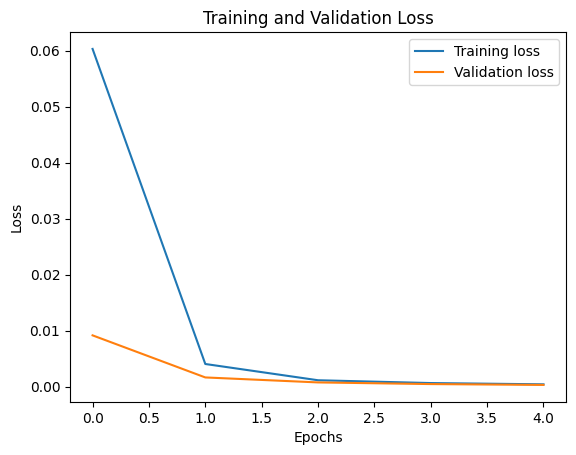

In [111]:
# Plot training and validation loss
plt.plot(history_min.history['loss'], label='Training loss')
plt.plot(history_min.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
Predicted failures for the next 7 minutes
[0.015458834, 0.015460141, 0.015463371, 0.015469071, 0.015478137, 0.015490182, 0.0155020105]

Mean Squared Error for Predictions: 0.0002

Mean Absolute Error for Predictions: 0.0155


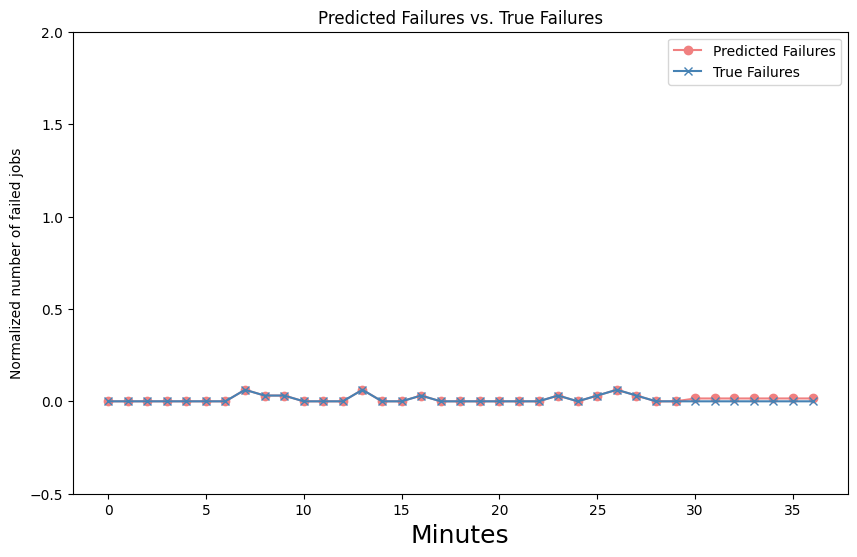

In [181]:
index_minute = 34  # Can be any valid starting point

input_data_minute = X_test_minute[index_minute]
previous_true_failures_minute = y_test_minute[index_minute:index_minute + sequence_length]

# Make predictions
predicted_failures_minute = predict_future_failures_hybrid(hybrid_model_attention_min, input_data_minute, input_data_minute, sequence_length, prediction_steps)

predicted_failures_with_previous_minute = np.concatenate([previous_true_failures_minute, predicted_failures_minute])

# Get the true failures for the specified number of minutes
true_failures_minute = y_test_minute[index_minute:index_minute + prediction_steps]

true_failures_with_previous_minute = np.concatenate([previous_true_failures_minute, true_failures_minute])

# Print the predicted failures
print("Predicted failures for the next 7 minutes")
print(predicted_failures_minute)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_minute - true_failures_minute)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_minute - true_failures_minute))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_with_previous_minute, label='Predicted Failures', color='lightcoral', marker='o')
plt.plot(true_failures_with_previous_minute, label='True Failures', color='steelblue', marker='x')
plt.xlabel('Minutes', fontsize=18)
plt.ylabel('Normalized number of failed jobs')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.ylim(-0.5, 2)
plt.grid(False)
plt.show()


# Comparison between Diff. Time Granularity

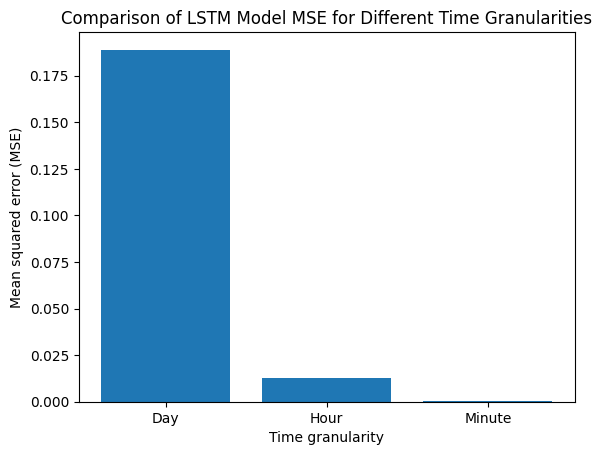

In [113]:
# Plot MSE for different time granularities
time_granularities = ['Day', 'Hour', 'Minute']
mse_values = [mse_day, mse_hour, mse_min]

plt.bar(time_granularities, mse_values)
plt.title('Comparison of LSTM Model MSE for Different Time Granularities')
plt.xlabel('Time granularity')
plt.ylabel('Mean squared error (MSE)')
plt.show()

# Model Comparison

## Attention Visualization

In [114]:
# Get the attention layer
attention_layer = hybrid_model_attention_day.layers[-1]  # Assuming the attention layer is the third last layer

# Check if the layer has trainable weights
if hasattr(attention_layer, 'get_weights') and len(attention_layer.get_weights()) > 0:
    attention_weights = attention_layer.get_weights()[0]
    # Visualize attention weights as needed
else:
    print("The selected layer does not have trainable weights.")


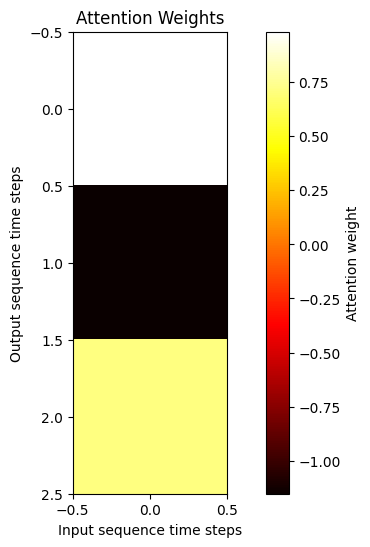

In [115]:
# Plot attention weights
plt.figure(figsize=(10, 6))
plt.imshow(attention_weights, cmap='hot', interpolation='nearest')
plt.xlabel('Input sequence time steps')
plt.ylabel('Output sequence time steps')
plt.title('Attention Weights')
plt.colorbar(label='Attention weight')
plt.show()

## Scalability and Efficiency Analysis 
### Time and Memory Complexity Analysis

In [116]:
# Define a function to profile memory usage
def profile_memory(func):
    mem_usage = memory_usage((func, ()))
    return max(mem_usage)


In [117]:
# Measure inference time for the hybrid model
start_time_day = time.time()
hybrid_model_attention_day.predict([X_test_day, X_test_day])
end_time_day = time.time()
inference_time_hybrid_day = end_time_day - start_time_day
print("Hybrid model inference time (Day):", inference_time_hybrid_day, "seconds")

start_time_hour = time.time()
hybrid_model_attention_hour.predict([X_test_hour, X_test_hour])
end_time_hour = time.time()
inference_time_hybrid_hour = end_time_hour - start_time_hour
print("Hybrid model inference time (Hour):", inference_time_hybrid_hour, "seconds")

start_time_minute = time.time()
hybrid_model_attention_min.predict([X_test_minute, X_test_minute])
end_time_minute = time.time()
inference_time_hybrid_minute = end_time_minute - start_time_minute
print("Hybrid model inference time (Minute):", inference_time_hybrid_minute, "seconds")

# Measure memory usage during model inference
memory_usage_day = profile_memory(lambda: hybrid_model_attention_day.predict([X_test_day, X_test_day]))
print("Hybrid model memory usage (Day):", memory_usage_day, "bytes")

memory_usage_hour = profile_memory(lambda: hybrid_model_attention_hour.predict([X_test_hour, X_test_hour]))
print("Hybrid model memory usage (Hour):", memory_usage_hour, "bytes")

memory_usage_minute = profile_memory(lambda: hybrid_model_attention_min.predict([X_test_minute, X_test_minute]))
print("Hybrid model memory usage (Minute):", memory_usage_minute, "bytes")


1/1 [==============================] - 0s 38ms/step
Hybrid model inference time (Day): 0.07885384559631348 seconds
 5/26 [====>.........................] - ETA: 0s

26/26 [==============================] - 0s 18ms/step
Hybrid model inference time (Hour): 0.5547447204589844 seconds
1035/1035 [==============================] - 19s 18ms/step
Hybrid model inference time (Minute): 19.26785111427307 seconds
1/1 [==============================] - 0s 91ms/step
Hybrid model memory usage (Day): 5157.9609375 bytes
26/26 [==============================] - 1s 21ms/step
Hybrid model memory usage (Hour): 5160.98046875 bytes
1035/1035 [==============================] - 19s 18ms/step
Hybrid model memory usage (Minute): 5165.03125 bytes
